In [1]:
import cv2
import numpy as np
from keras.models import load_model
from wide_resnet import WideResNet
import face_recognition
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from pylab import rcParams
plt.style.use('ggplot')


/anaconda3/envs/kerasv6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
class VideoBuddy:
    def __init__(self, video_path, sub_sample=10, 
                 batch_size=128, verbosity=True, 
                 emotion_thr=0.3, gender_thr=0.5,
                 default_models=True, method='hog'):
        
        # Create opencv video instance
        self.stream = cv2.VideoCapture(video_path)
        self.sub_sample = sub_sample
        self.batch_size = batch_size
        self.verbosity = verbosity
        self.emotion_thr = emotion_thr
        self.gender_thr = gender_thr
        # Set control flags & counters
        self.default_models = True
        self.method = method
        self.stopped = False
        self.batch_counter = 0
        self.image_counter = 0
        # Intialize lists
        self.emotions = []
        self.gender = []
        self.age = []
        self.nb_faces = []
        self.str_predictions = [] # Human readible predictions to plot video
        self.video_frames = [] # List to generate a rendered & annotated video
        # Set default model paths 
        self.emotion_model_path = 'pretrained_models/fer2013_mini_XCEPTION.102-0.66.hdf5'
        self.age_gender_model_path = 'pretrained_models/weights.18-4.06.hdf5'
        
        # Parches
        self.gray_img = 0
        self.color_img = 0

        
    def set_models(self):
        # Load default models
        if self.default_models:
            self.emotion_model = load_model(self.emotion_model_path)        
            self.ag_model = WideResNet(64, depth=16, k=8)()
            self.ag_model.load_weights(self.age_gender_model_path)
            print('Prediction models successfully loaded...')
            
    def update_video_path(self, video_path):
        self.stream = cv2.VideoCapture(video_path)
           
        
    def read(self):
        # Check if the video is no ended
        if self.stopped:
            return
        # Get current frame from OpenCV iterable
        success, frame = self.stream.read()
        # Set the 
        if not success:
            self.stopped = True
            print('Video Succesfully Analysed. {} images processed'.format(self.image_counter))
            return
        # Update image counter
        self.image_counter = self.image_counter + 1
        return frame
    
    
    def batch_gen(self):
        # Generate batchs of frames from the video iterator
        # It would be very nice to apply the downsample rule before reading
        #for i in range(self.batch_size):
            # we only append elements that are consistent with the sub_sampling
            #indexes = [k*i for in in range(self.batch_size*k)]
            # read all frames
            # self.read()
            # Keep only the desired
            #if i == indexes[i]:
                #self.batch.append(self.frame)
        # Generate the batch
        self.batch = [self.read() for index in range(int(self.batch_size))]
        return 

    
    def analyze(self):
        # Main loop / Check if the video has not finish
        while not self.stopped:
            # Generate a current batch
            self.batch_gen()
            
            # Detect all faces on the batch
            # This method subsample the batch.
            # For each image on the batch find the locations of all faces
            # For each face call inmediatly the predict method
            self.face_detection()
            
            # Show some info
            if self.verbosity and not self.stopped:            
                self.batch_counter = self.batch_counter + 1
                print('Analyzing batch {}. Elapsed time ='.format(self.batch_counter))
                     
            
    def face_detection(self):
        # Implementation made by the face_detection team based on dlib
        # Dowsample the batch / Partial solution
        self.batch = self.batch[::self.sub_sample]
        
        for frame in self.batch:
            # Verify if it is the last batch
            if frame is None:
                self.stopped = True
        
        if not self.stopped:
            # Reduce the image size to speed the process
            self.small_batch = [cv2.resize(frame, (0, 0), fx=0.25, fy=0.25) 
                                      for frame in self.batch]
            # Convert images to RGB
            self.small_batch = [frame[:, :, ::-1] for frame in self.small_batch]
            # Call face_recognition method to find faces using the desired method.
            # This method return the numpy coordinates to crop the image. It is computed on the batch
            
            # Each image in the batch can have several faces.. Then it is necessary to call the prediction loop
            # for each image found on the video
            
            for index, small_frame in enumerate(self.small_batch):
                self.frame = self.batch[index]
                self.small_frame = small_frame
                #print('big frame = ', np.shape(self.frame))
                #print('small frame = ', np.shape(self.small_frame))
                # Get the face locations of the current frame. Store the coordinates
                # The current frame is stored as a variable
                self.face_locations = face_recognition.face_locations(self.small_frame, model=self.method,
                                                                      number_of_times_to_upsample=3)
                
                #print('face location len of current frame = ', len(self.face_locations))
                self.nb_faces.append(len(self.face_locations))

                # Call the iterator of predictions
                for self.face in self.face_locations:
                    self.predict()        
        return

    
    def predict(self):
        # This method is called for each image on the batch
        # The reason is that one image can have several images
        # This loop has been taken from the face_recognition GitHub
        #for face in self.face_locations:
            # Keep the number of detected faces for final statistics
        # Get face coordinates usign tupple unpacking
        top, right, bottom, left = self.face
        # Crop current small frame
        self.face_frame = self.small_frame[top:bottom, left:right]
        # Pre-process current frame. This method returns the 
        # needed input shape for the two Keras models
        self.pre_processing()
        # Call inference with the respectives color and B&W frames
        self.predicted_emotion = self.emotion_model.predict(self.gray_img)
        predicted_ag = self.ag_model.predict(self.color_img)
        # Decode emotions from all faces of the current frame
        self.predicted_gender = predicted_ag[0]
        age = np.arange(0, 101).reshape(101, 1)
        self.predicted_age = predicted_ag[1].dot(age).flatten()

        # Append predictions to main lists
        # Emotion and gender thresholds are not implemented!!!
        self.emotions.append(np.argmax(self.predicted_emotion))
        self.gender.append(np.argmax(self.predicted_gender))
        self.age.append(int(self.predicted_age))

        render_video = True
        if render_video:
            # Generate human readible predictions to plot on video
            str_age = str(self.predicted_age)[1:3] #emotion_decoder(emotion_output, 0.30)
            # Decode gender and emotion to human readible string
            #self.str_emotion
            #self.str_gender
            self.gender_decoder()
            self.emotion_decoder()
            # Create text to add on the rectangle
            annotations = self.str_emotion + '\n' + self.str_gender + '\n' + str_age + ' ' + 'years'
            # Save all string predictions of the given frame
            # These predictions are going to be annotated on the frames
            self.str_predictions.append(annotations)
            #print('Str annotations', annotations)
            # Annotate and save the frames
            self.annotate_frame()


    def pre_processing(self):
        # Convert image to B&W for emotion model
        gray_img = cv2.cvtColor(self.face_frame,cv2.COLOR_BGR2GRAY)
        #print('small FACE img = ', np.shape(self.small_frame))
        #print('gray img FACE= ', np.shape(gray_img))

        gray_img = np.array(gray_img).astype('float32')
        gray_img = gray_img / 255.0
        gray_img = gray_img - 0.5
        gray_img = gray_img * 2.0
        gray_img = cv2.resize(gray_img,(64,64), interpolation = cv2.INTER_CUBIC)
        gray_img = np.reshape(gray_img,(64,64,1))
        # Not good :()
        self.gray_img = np.expand_dims(gray_img, axis=0)

        # Color image for age and gender model
        color_img = cv2.resize(self.face_frame,(64,64), interpolation = cv2.INTER_CUBIC)
        color_img = np.reshape(color_img,(64,64,3))
        self.color_img = np.expand_dims(color_img, axis=0)
        return 

    
    def annotate_frame(self):
        # Annontate frames 
        for (top, right, bottom, left), emotion in zip(self.face_locations, self.str_predictions):
                # Scale back up face locations since the frame we detected in was scaled to 1/4 size
                top *= 4
                right *= 4
                bottom *= 4
                left *= 4

                # Create a copy of the frame as overlay big frame
                overlay = self.frame.copy()

                # Draw a box around the face
                cv2.rectangle(overlay, (left, top), (right, bottom), (180, 0, 0), 2) #Blue

                # Plot predictions
                font = cv2.FONT_HERSHEY_DUPLEX
                y0, dy = 0, 30
                for i, line in enumerate(emotion.split('\n')):
                    y = y0 + i*dy
                    cv2.putText(overlay, line, (left + 6, bottom - 6 + y), font, 1.0, (255, 255, 255), 1)
                opacity = 0.5
                cv2.addWeighted(overlay, opacity, self.frame, 1 - opacity, 0, self.frame)

                # Append all procesed to render a final video
                self.video_frames.append(self.frame)            


    def save_video(self):
        # Create video writer
        writer = cv2.VideoWriter("my_video.avi", 
                     cv2.VideoWriter_fourcc(*"MJPG"), 
                     40,(np.array(self.video_frames).shape[2], 
                         np.array(self.video_frames).shape[1]))

        for frame in self.video_frames:
            writer.write(frame.astype('uint8'))

        writer.release()
        print('Video sucessfully writen...')
        return


    def gender_decoder(self):
        net_output = self.predicted_gender
        if np.max(net_output) > self.gender_thr:
            probability = str(np.max(net_output))
            if np.argmax(net_output) == 0:
                prediction = 'female'
            else:
                prediction = 'male'
        else:
            prediction = ''
            probability = ''

        self.str_gender = prediction + ' ' + probability[:5] 
        return

    
    def emotion_decoder(self):
    # Check if probability is higher than threshold
        net_output = self.predicted_emotion
        #if np.max(net_output) >= self.emotion_thr:
        probability = str(np.max(net_output))
        if (np.argmax(net_output) == 0):
            prediction = 'angry'
        elif (np.argmax(net_output) == 1):
            prediction = 'disgust'
        elif (np.argmax(net_output) == 2):
            prediction = 'fear'
        elif (np.argmax(net_output) == 3):
            prediction = 'happy'
        elif (np.argmax(net_output) == 4):
            prediction = 'sad'
        elif (np.argmax(net_output) == 5):
            prediction = 'surprise'
        else:
            prediction = 'neutral'
        #else:
            # Do not label the box if you are not sure
        #    prediction = ''
        #    probability = ''
            
        self.str_emotion = prediction + ' ' + probability[:5]
        return 
    
    
    def plot(self):
        rcParams['figure.figsize'] = 16, 16
        fig = plt.figure()
        fig1 = fig.add_subplot(411)
        fig2 = fig.add_subplot(412)
        fig3 = fig.add_subplot(413)
        fig4 = fig.add_subplot(414)

        my_xticks = 'Angry Disgust Fear Happy Sad Surprise Neutral'.split()

        ax1 = sns.kdeplot(self.emotions, shade=True, ax=fig1)
        ax1.set(xticks=range(0, 7), xticklabels=my_xticks)
        ax1.set_title('Emotion')

        ax2 = sns.kdeplot(self.gender, shade=True, ax=fig2)
        ax2.set(xticks=range(0, 2), xticklabels=['female', 'male'])
        ax2.set_title('Gender')
        
        ax3 = sns.kdeplot(self.age, shade=True, ax=fig3)
        ax3.set_title('Age')

        ax4 = sns.kdeplot(self.nb_faces, shade=True, ax=fig4)
        ax4.set_title('Number of faces')
        return 


In [3]:
video_path = './Videos/sad_affleck.mp4'
#video_path ='./Videos/test_m6.mp4'
vid = VideoBuddy(video_path, sub_sample=20, 
                 batch_size=128, verbosity=True, 
                 emotion_thr=0.3, gender_thr=0.5)


In [4]:
# Wrap models to class
vid.set_models()

/anaconda3/envs/kerasv6/lib/python3.6/site-packages/keras/models.py:318: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


Prediction models successfully loaded...


In [5]:
# Update video to analyze
vid.update_video_path('./Videos/test_m6.mp4')

In [6]:
# Perform sentiment analysis
# Option 1 if you want only the statistics
vid.analyze()

# Option 2 if you want to render a video
# in this case sub_sample is not possible

Analyzing batch 1. Elapsed time =
Analyzing batch 2. Elapsed time =
Analyzing batch 3. Elapsed time =
Analyzing batch 4. Elapsed time =
Analyzing batch 5. Elapsed time =
Analyzing batch 6. Elapsed time =
Analyzing batch 7. Elapsed time =
Analyzing batch 8. Elapsed time =
Analyzing batch 9. Elapsed time =
Analyzing batch 10. Elapsed time =
Analyzing batch 11. Elapsed time =
Analyzing batch 12. Elapsed time =
Analyzing batch 13. Elapsed time =
Analyzing batch 14. Elapsed time =
Analyzing batch 15. Elapsed time =
Analyzing batch 16. Elapsed time =
Analyzing batch 17. Elapsed time =
Analyzing batch 18. Elapsed time =
Analyzing batch 19. Elapsed time =
Analyzing batch 20. Elapsed time =
Analyzing batch 21. Elapsed time =
Analyzing batch 22. Elapsed time =
Analyzing batch 23. Elapsed time =
Video Succesfully Analysed. 3040 images processed


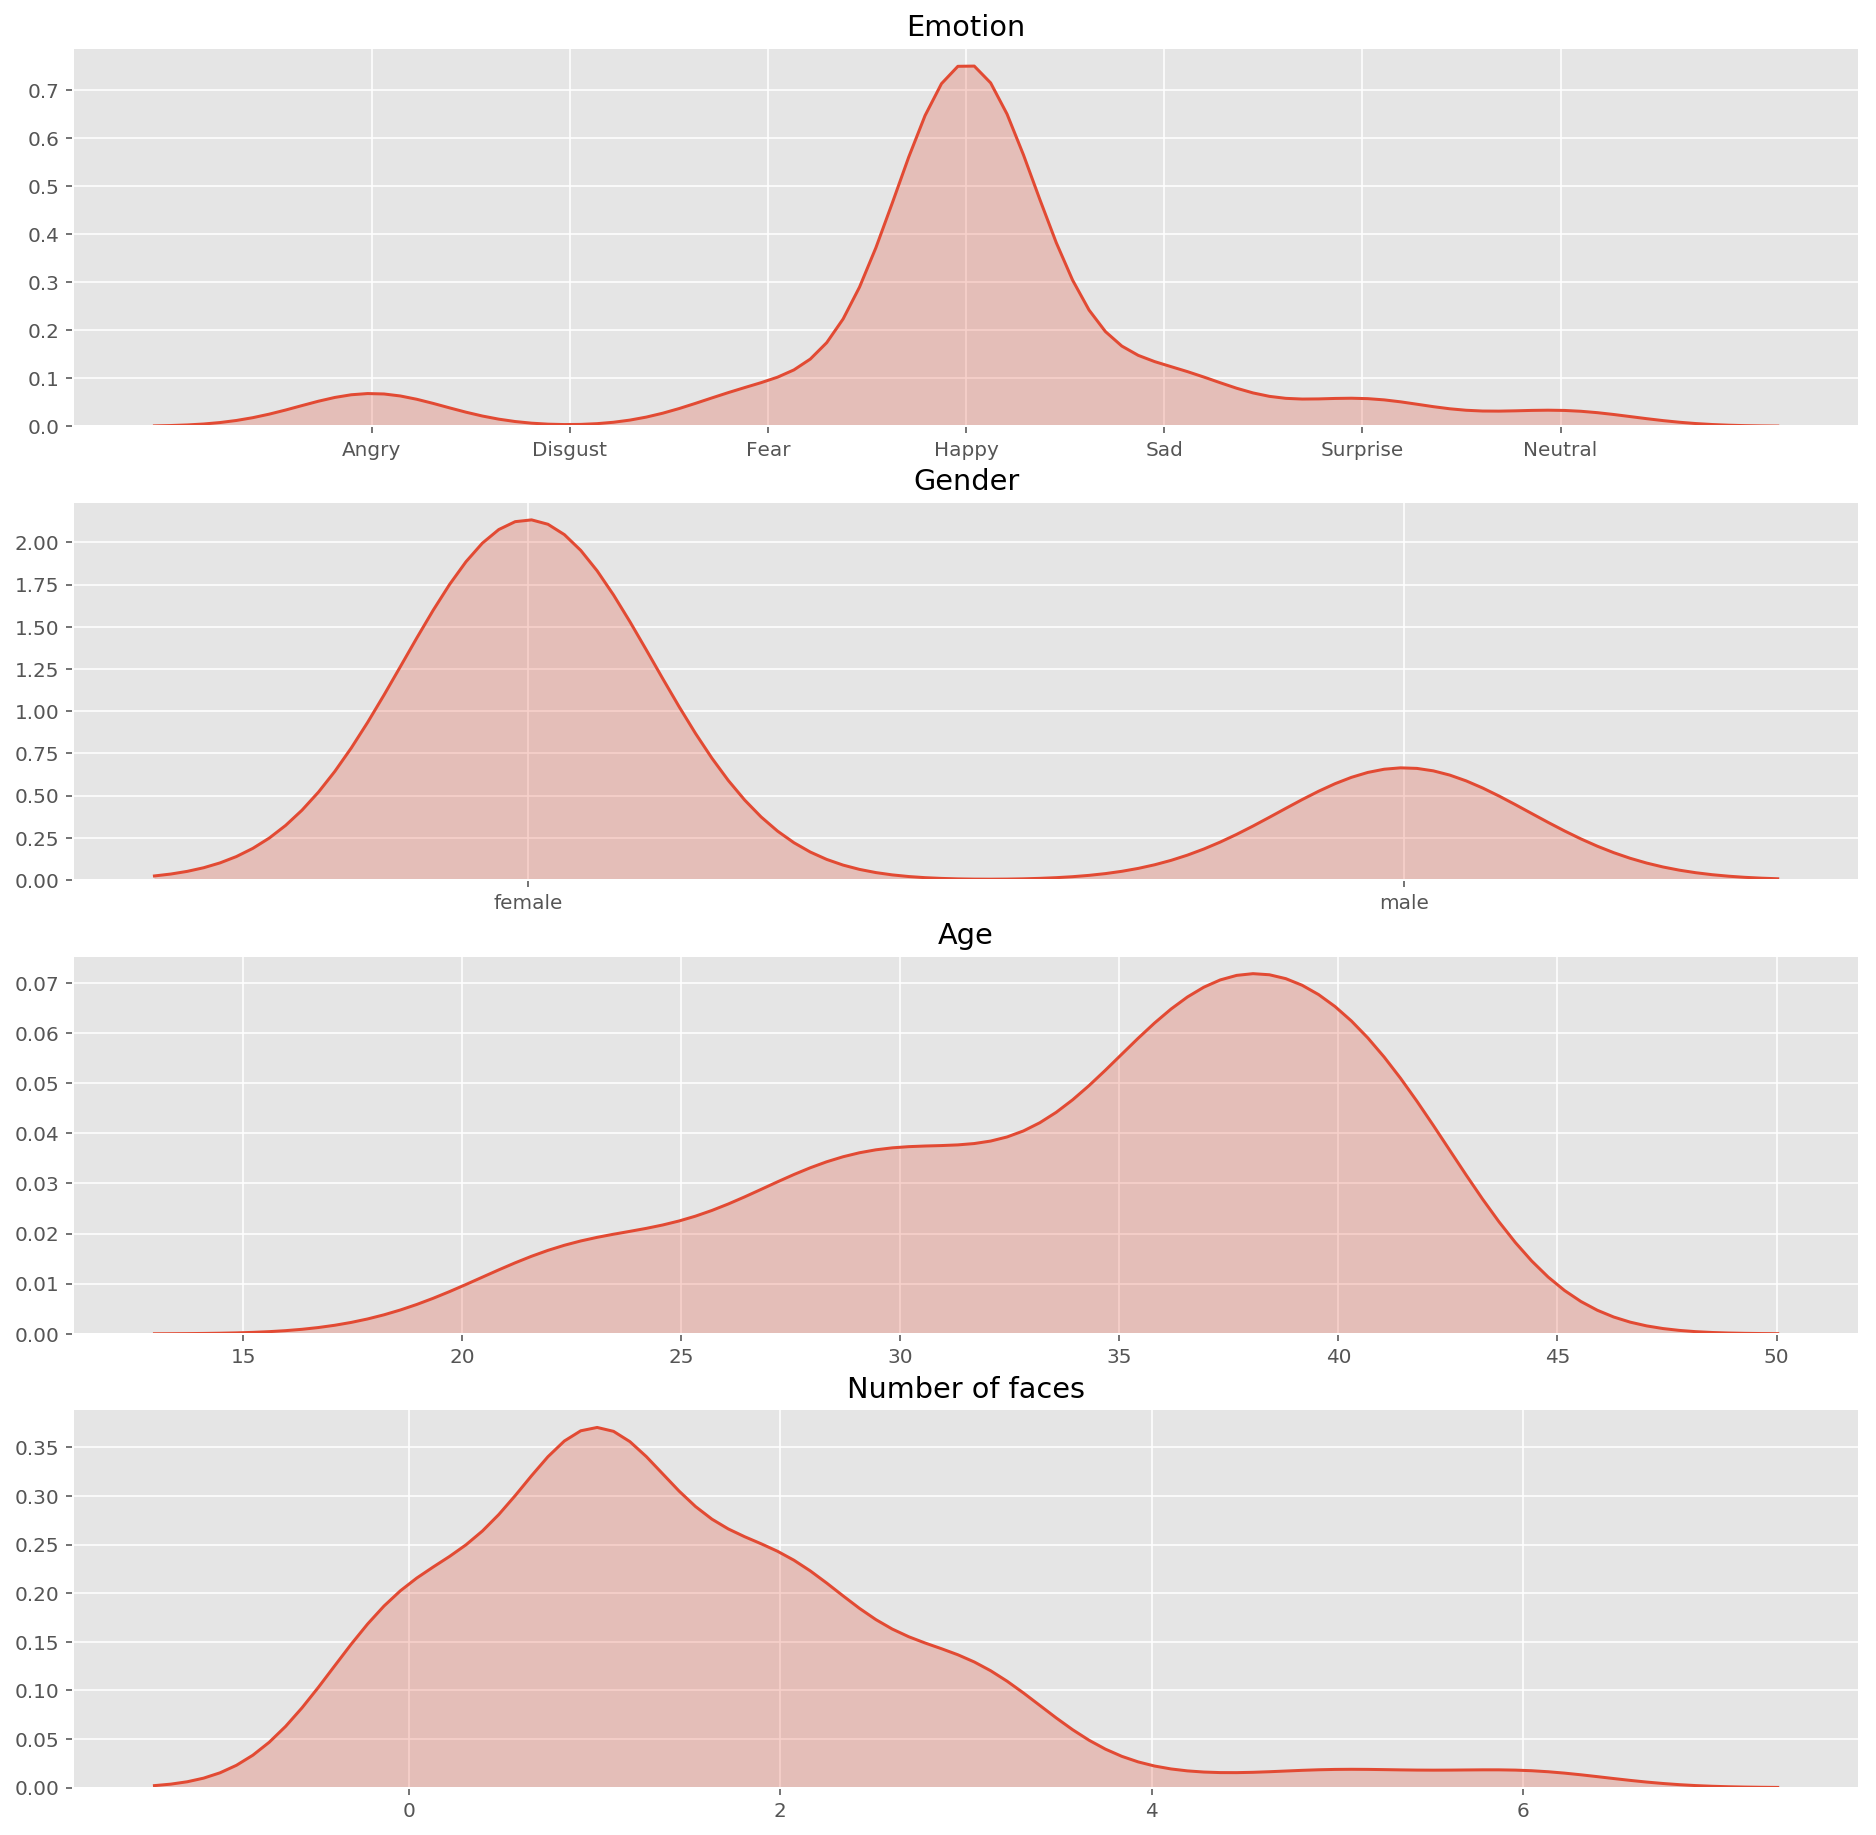

In [7]:
# Plot statistics
vid.plot()

In [8]:
# Generate video with human readible annotations :)
vid.save_video()

Video sucessfully writen...


### Cosas a hacer
    - Implementar la prediccion por batches. 
    - Hacer un rendering sin ser afectado por el subsample.
    - No confundir funciones con metodos
    - Hacer atencion al uso de la memoria
    - Implementat el metodo plot
    - Imprimir las estadisticas basicas
    - No es logico tener que cargar los modelos cada vez que cambias de video.
      Debe haber una manera de asignar el path para analizar con los mismos modelos